# Методы восстановления регрессии

Задачу обучения по прецедентам при $Y=\mathbb{R}$ принято называть задачей восстановления регрессии. Задано пространство объектов X и множество возможных ответов Y. Существует неизвестная целевая зависимость $y^*:X\rightarrow Y$ , значения которой известны только на объектах обучающей выборки $X^\ell = (x_i, y_i)_{i-1}^\ell, y_i = y^* (x_i)$. Требуется построить алгоритм, который в данной задаче принято называть "функцией регрессии" $a: X^* \rightarrow Y$ , аппроксимирующий целевую зависимость $y^*$.

 ## lowess
 
Для начала настроим окружение jupiter notebook:

In [25]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

И установим внешние зависимости:

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plot

plot.rcParams['figure.figsize'] = (15, 6)

Обучающую выборку сгенирируем сами на основе функции синуса, и добавим к нему выбросы, чтобы продемонстрировать преимущества *lowess* над обычной *непараметрической регрессии*.
Возьмем синус от $-4\Pi$ до $4\Pi$, размер выборки 150, величину отклонения выброса в 3 и частоту выбросов в 10% (будет примерно 15 выбросов на всю выборку).

In [27]:
import regression.datasets as datasets

size = 150
data = datasets.sin_with_error(-4 * np.pi, 4 * np.pi, size, error=3, rate=0.1)
xl, yl = data['xl'], data['yl']

Получили следующую выборку:

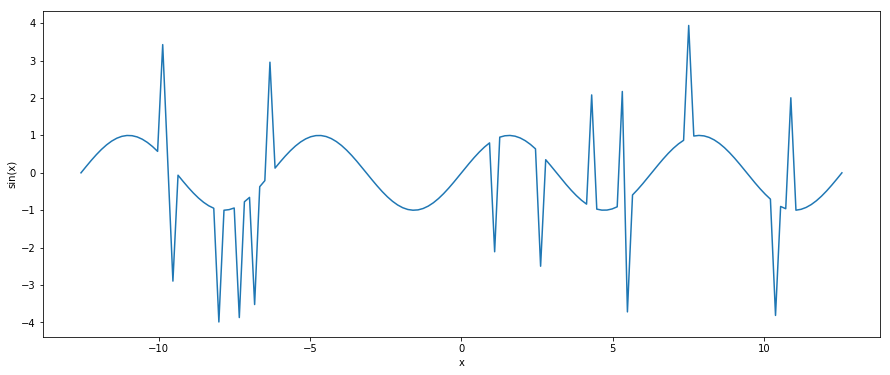

In [28]:
plot.plot(xl, yl)
plot.xlabel('x')
plot.ylabel('sin(x)')
plot.show()

### Проблема выбросов
Оценка Надарайя–Ватсона крайне чувствительна к большим одиночным выбросам. Чем больше величина ошибки $\varepsilon_i$, тем в большей степени прецедент $(x_i, y_i)$ является выбросом, и тем меньше должен быть его вес. Эти соображения приводят к идее домножить веса $w_i(x)$ на коэффициенты $\gamma_i = \overline{K(\varepsilon_i)}$, где $\overline{K(\varepsilon_i)}$ – ещё одно ядро, отличное от ядра регрессии.

Общий алгоритм имеет следующий вид:

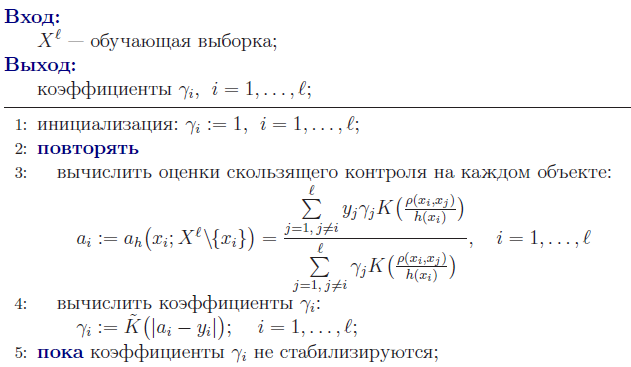

In [29]:
def calc_weights(xl, yl, h, stable_limit):
    size = len(xl)
    w = np.ones(size)

    for iteration in range(50):  # Чтобы не итерироваться бесконечно
                                 # в случае несходимости
        yl_est = lowess_loo_estimate(xl, yl, w, h)

        w_next = __recalc_w(np.abs(yl - yl_est))
        if __is_stable(w, w_next, stable_limit):
            break

        w = w_next

    return w

Функция `lowess_loo_estimate` вычисляет ответ алгоритма регрессии на всей выборке, пошагово исключая каждый $x_i$, чтобы алгоритм не запоминал $y_i$, а обучался по соседним ответам.

In [30]:
import regression.kernels as kernels
from regression.utils import distance

def lowess_loo_estimate(xl, yl, w, h):
    size = len(xl)
    return list(map(lambda i: lowess_loo(i, xl, yl, w, h), range(size)))


def lowess_loo(i, xl, yl, w, h):
    return lowess(xl[i], np.delete(xl, i), np.delete(yl, i),
                  np.delete(w, i), h)


def lowess(x, xl, yl, w, h):
    top, bottom = 0, 0
    for i, x_i in enumerate(xl):
        k = kernels.gauss(distance(x, x_i) / h)
        top += yl[i] * k * w[i]
        bottom += k * w[i]

    return float('inf') if bottom == 0 else top / bottom

Обратите внимание, так как рекомендуется, чтобы ядро при подборе весов отличалось от ядра регрессии, и при подборе весов используется *квартическое ядро*, ядро регрессии *гаусово*.

Функция `__recalc_w` просчитывает значения весов, пропуская их через "мягкую фильтрацию". *Мягкая фильтрация* пропускает ошибки алгоритма на шаге итерации через квартическое ядро, деля на медиану * 6:

In [31]:
def __recalc_w(errors):
    median = np.median(errors)

    seq = map(lambda error: 0 if error == float('inf') else
              kernels.quartic(error / (6 * median)), errors)
    
    return np.fromiter(seq, dtype=np.double)

Функция `__is_stable` проверяет, стабилизировались ли веса на шаге итерации. Веса стабилизировались, когда каждый следующий вес отличается от предыдущего не больше, чем на $\varepsilon$ (`stable_limit`)

In [32]:
def __is_stable(w1, w2, eps):
    diff = np.abs(w1 - w2)

    for d in diff:
        if d > eps:
            return False
    return True

Как и в случае с *непараметрической регрессией* параметр "ширины окна" нужно подбирать отдельно, запуская алгоритм с определенной шириной окна и выбирая с наименьшей ошибкой.

In [33]:
def calc_h_errors(xl, yl, hl, stable_limit):
    h_errors = []

    for h in hl:
        weights = calc_weights(xl, yl, h, stable_limit)

        h_error = 0
        for i, x in enumerate(xl):
            y_r = lowess_loo(i, xl, yl, weights, h)
            h_error += (y_r - yl[i]) ** 2
        h_errors.append(h_error)

    return h_errors

Запустим алгоритм *непараметрической регрессии* и *lowess* на одинаковых данных с выбросами и сравним результаты. Для этого в кажом случае:

1. Пропускаем массив предполагаемых значений окон *hl* через _LOO_, чтобы выбрать окно с наименьшей ошибкой.
2. Для наилучшего окна вычисляем значения регрессии.
3. Выводим результат
4. Сравниваем ошибки алгоритмов.

1. **Непараметрическая регрессия**

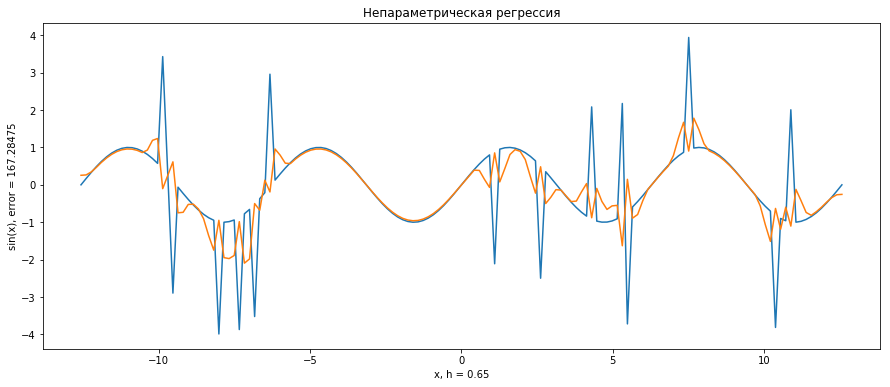

In [34]:
from regression.nw.nw import nw_loo_estimate,\
                             calc_h_errors as nw_calc_h_errors

def plot_nw(xl, yl):
    hl = np.arange(0.2, 0.7, 0.05) # значения окна в этом промежутке
                                   # для квартических ядер

    h_errors = nw_calc_h_errors(xl, yl, hl, kernels.quartic)
    min_i = np.argmin(h_errors)
    h_error = round(h_errors[min_i], 5)
    best_h = hl[min_i]

    yl_est = nw_loo_estimate(xl, yl, best_h, kernels.quartic)

    plot.plot(xl, yl)
    plot.plot(xl, yl_est)
    plot.xlabel('x, h = ' + str(round(best_h, 2)))
    plot.ylabel('sin(x), error = ' + str(h_error))
    plot.title("Непараметрическая регрессия")
    
    
plot_nw(xl, yl)

**Ошибка: 167.284**

2. **lowess**

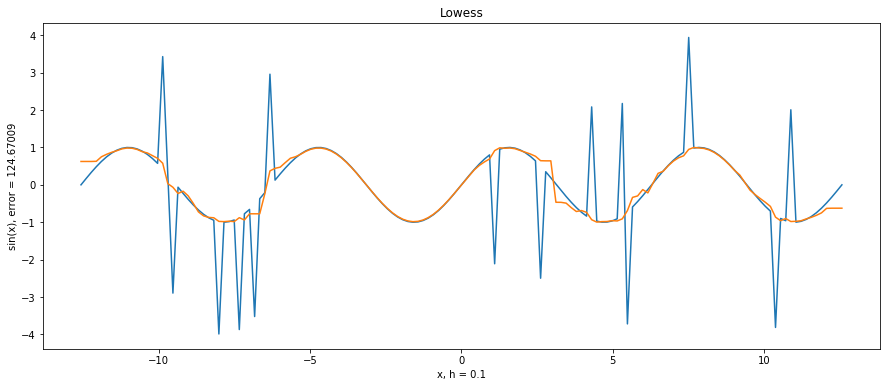

In [35]:
def plot_lowess(xl, yl, stable_limit):
    hl = np.arange(0.05, 0.3, 0.05) # значения окна в этом промежутке
                                    # для гаусовских ядер

    h_errors = calc_h_errors(xl, yl, hl, stable_limit)
    min_i = np.argmin(h_errors)
    h_error = round(h_errors[min_i], 5)
    best_h = hl[min_i]

    weights = calc_weights(xl, yl, best_h, stable_limit)
    yl_est = lowess_loo_estimate(xl, yl, weights, best_h)

    plot.plot(xl, yl)
    plot.plot(xl, yl_est)
    plot.xlabel('x, h = ' + str(round(best_h, 2)))
    plot.ylabel('sin(x), error = ' + str(h_error))
    plot.title("Lowess")
    
    
plot_lowess(xl, yl, 0.001)

#### Итоги

Ошибка *непараметрической регрессии* при лучшем окне составляет 167.284, ошибка *lowess* – 124.67. На числах результат не сильно больше, однако ответ *lowess* гораздо ценнее, ведь она старается сохранить первоначальный вид функции (синуса), в отличие от *непараметрической регрессии*, которая старается угнаться за выбросами и в итоге ее ответ сильно шумит.

Обучение *lowess* отличается сложностью на порядок, в результате чего время выполнения ее сильно дольше, однако применение алгоритма имеет одинаковое время работы, а результат *lowess* точнее к истинному ответу.